                                             
Optimize [imag3] - start penalty: 7375                         
Matching: model call n. 175 penalty = 3.3912e-12              
Optimize [imag3] - end penalty:  3.39118e-12                            
                                             
Optimize [sfx1r_d] - start penalty: 865.2                         
Matching: model call n. 174 penalty = 1.1225e-09              
Optimize [sfx1r_d] - end penalty:  1.12255e-09                            
                                             
Optimize [sfx1r_cd] - start penalty: 1.123e-09                         
Matching: model call n. 2 penalty = 1.1225e-09              
Optimize [sfx1r_cd] - end penalty:  1.12255e-09                            
                                             
Optimize [rmat_sext] - start penalty: 1.985                         
Matching: model call n. 56 penalty = 4.5309e-11              
Optimize [rmat_sext] - end penalty:  4.53092e-11                       

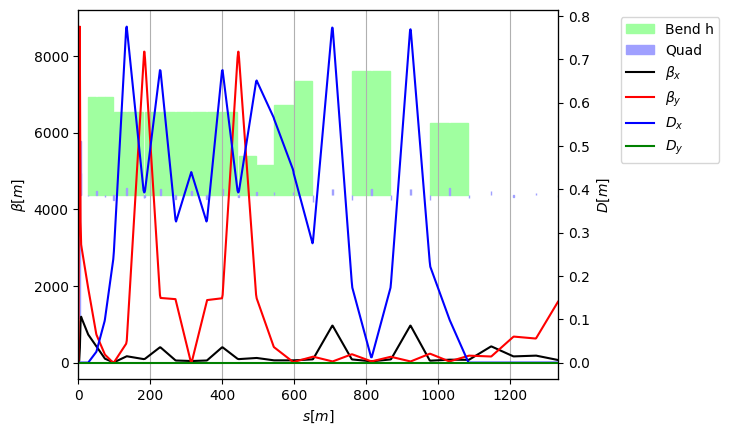

In [3]:
import numpy as np
import xtrack as xt

env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')
env.call('../002_design_optics/matching_constraints.py')
env.vars.load_json('strengths_quads_03_ffccsyr.json')



line = -env['ccs_yr'] + (-env['ccs_xr'])

tt0 = line.get_table(attr=True)
tt0_quad = tt0.rows[tt0.element_type == 'Quadrupole']
tt0_sext = tt0.rows[tt0.element_type == 'Sextupole']

kq = {}
kq['section_c'] = ['kqd07r', 'kqf08r', 'kqd09r', 'kqf10r']
kq['section_d'] = ['kqd11r', 'kqf12r']
kq['xquads'] = ['kqx00r', 'kqx01r', 'kqx02r']
kq['section_e'] = ['kqf13r', 'kqd14r', 'kqf15r', 'kqd16r',
                   'kqf17r', 'kqd18r', 'kqf19r', 'kqd20r']

# Build vary objects keeping the initial signs
vary_kq = {}
for kk in kq.keys():
    vary_kq[kk] = []
    for nn in kq[kk]:
        vv = env[nn]
        vary_kq[kk].append(xt.Vary(nn, step=1e-10, tag=kk)) # Note the small step
vary_all = []
for kk in kq.keys():
    vary_all += vary_kq[kk]

tar_sfm2r = xt.TargetSet(betx=xt.LessThan(60.0),
                     bety=xt.LessThan(20.0),
                     alfx=xt.GreaterThan(0.),
                     dx=xt.GreaterThan(env['dx_sfmr']),
                     at='sfm2r::0')

tar_sfx1r= xt.TargetSet(
                     betx=xt.LessThan(965),
                     alfx=0,
                     bety=xt.LessThan(50.),
                     dx=xt.LessThan(1.),
                     mux=1.75 - 0.007,
                     at='sfx1r::1')

tar_rmat_sext = xt.TargetRmatrix(start='sfx1r::1', end='sfx2r::1',
                        r12=env['r12_ccsxl'], r34=env['r34_ccsxl'],
                        r11=-1, r33=-1)

tar_imag4 = xt.TargetSet(betx=xt.GreaterThan(0.5), bety=xt.LessThan(35.),
                         alfx=0, alfy=0.18,
                         dx=xt.GreaterThan(0.001),
                         dpx=env['dpx_ccxr'],
                         at='ipimag4')

tar_rmat_end = xt.TargetRmatrix(start=xt.START, end=xt.END,
                                r33=0, r12=0)

tar_end = xt.TargetSet(betx=env['bx_ff_out'], alfx=0.0,
                       bety=env['by_ff_out'], alfy=0.0,
                       dx=env['dx_ff_out'], dpx=0.0,
                       mux=3.0, muy=2.75, at=xt.END)

# Initialize quads with a small strength
for vv in vary_all:
    nn = vv.name
    if env.vars.vary_default[nn]['limits'][1] > 1e-3:
        env[nn] = 1e-3
    else:
        env[nn] = -1e-3

# wipe sextupoles
for kk in ['ksdy1r', 'ksdy2r', 'ksdm1r', 'ksdm1r', 'ksfm2r',
           'ksfx1r', 'kcrabr']:
    env[kk] = 0.

# Match ipimag3
opt_sfm2r = line.match(
    name='imag3',
    solve=False,
    betx=env['bxip'],
    bety=env['byip'],
    targets=[tar_sfm2r,
             xt.TargetSet(dx=xt.LessThan(0.45), at='qf10r')],
    vary=vary_kq['section_c']
)
opt = opt_sfm2r
opt.step(100)

# March to sfx1
opt_sfx1r = opt_sfm2r.clone(name='sfx1r_d',
                              add_vary=vary_kq['section_d'],
                              add_targets=tar_sfx1r)
opt = opt_sfx1r
opt.step(100)

opt_more_sfx1r = opt_sfx1r.clone(name='sfx1r_cd',
                           add_vary=vary_kq['section_c'])
opt = opt_more_sfx1r
opt.step(100)


# Match r matrix alone
opt_rsext = line.match(
    name='rmat_sext',
    solve=False,
    start='sfx1r::1', end='sfx2r::1',
    init_at='ipimag4',
    betx=0.20, bety=0.20, # Rough estimate
    targets=tar_rmat_sext,
    vary=vary_kq['xquads'])

opt = opt_rsext
opt.disable(target=True)
opt.enable(target=0)
opt.step(20)
opt.enable(target=1)
opt.step(20)
opt.enable(target=2)
opt.step(20)
opt.enable(target=3)
opt.step(20)

# Imag 4 without r matrix
opt_imag4 = opt_more_sfx1r.clone(name='imag4',
                                 add_targets=tar_imag4)
opt = opt_imag4

# Focus on optics at sextupole
opt_imag4.disable(target=True)
opt_imag4.enable(target='sfx1r.*')
opt.step(200)
opt.enable(target=True)

# Add rmatrix and qy quads
opt_imag4_with_qy = opt_imag4.clone(
    name='imag4_with_qy',
    add_vary=vary_kq['xquads'],
    add_targets=tar_rmat_sext)
opt = opt_imag4_with_qy
opt.enable(True)
opt.step(100)

opt.targets['ipimag4_dpx'].weight = 1000
opt.step(100)

# Try to close with downstream quadrupoles alone
opt_end = opt_imag4_with_qy.clone(
    name='end',
    remove_vary=True,
    remove_targets=True,
    add_vary=vary_kq['section_e'],
    add_targets=[tar_end,
                 xt.TargetSet(dx=0, dpx=0, at='qf17r'), # to prevent dx going wild in the straight
    ]
)
opt = opt_end

opt.disable(target='END_mu.*')
opt.step(100)
opt.enable(target='END_mu.*')
opt.step(100)

opt.targets[5].weight = 1000
opt.step(100)

# Refine with symplex
opt_imag4_with_qy._step_simplex(1000)
opt_end._step_simplex(1000)

opt_full = opt_end.clone(
    name='full',
    add_targets=opt_imag4_with_qy.targets,
    add_vary=opt_imag4_with_qy.vary
)
opt = opt_full
opt.step(200)

opt_full.run_simplex(1000)

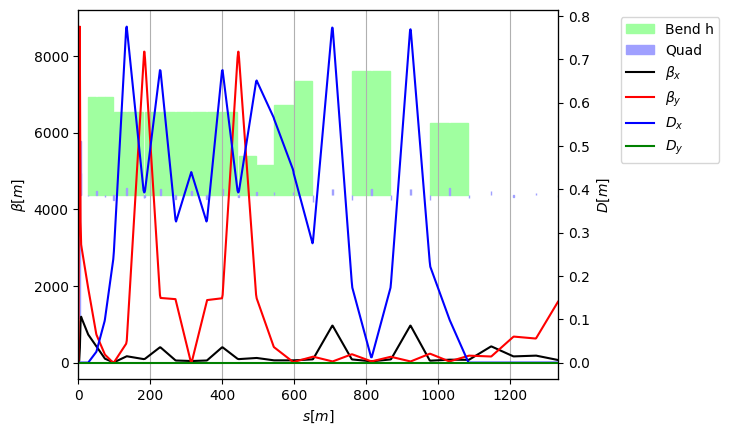

In [4]:
opt.plot()

In [6]:
strengths = opt_full.get_knob_values()
xt.json.dump(strengths, 'strengths_quads_04_ffccsxr.json')

In [7]:
!cat strengths_quads_04_ffccsxr.json

{
 "kqf13r": 0.017981081596935185,
 "kqd14r": -0.016508608189081418,
 "kqf15r": 0.020879582233888867,
 "kqd16r": -0.009357052346274358,
 "kqf17r": 0.010203022929429517,
 "kqd18r": -0.005710319859750431,
 "kqf19r": 0.00633898194693838,
 "kqd20r": -0.0075887107371790125,
 "kqd07r": -0.00693808351860903,
 "kqf08r": 0.008421673509035053,
 "kqd09r": 0.007711103801969328,
 "kqf10r": 0.008693726213785183,
 "kqd11r": -0.021192657917575502,
 "kqf12r": 0.016493401331136255,
 "kqx00r": 0.016534197521355983,
 "kqx01r": -0.016449969680919038,
 "kqx02r": 0.016518982646894893
}